In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='serif')
from operator import itemgetter
from astropy.io import fits, ascii
from astropy.table import Table
import os
import math

import TheCannon
from TheCannon import apogee, dataset
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2016/bin/x86_64-darwin'

### Train SPT and Teff/[Fe/H] Models

In [16]:
west_dfile    = AP_PATH + '/training_sets/west_sample_cut/'
west_rfile    = 'train_ref/west_ref_labels.csv' 
west_tr_label = ap.loadLabels(west_rfile, lbl_names=['SPT'])
west_tr_unc   = np.array([[1] for i in west_tr_label])
west_ds       = ap.initializeTrainingSet(data=west_dfile, ref=west_rfile, lbl_names=['SPT'], save_base='west_cut')

This is the right version
Loading spectra from directory /home/jess/Desktop/Research/apogee_data/training_sets/west_sample_cut/
Spectra loaded
Loading dataset
This may take a while...
Loaded /home/jess/Desktop/Research/apogee_data/training_sets/norm_fluxes/west_cut_norm_tr_flux.npy
Loaded /home/jess/Desktop/Research/apogee_data/training_sets/norm_fluxes/west_cut_norm_tr_ivar.npy


In [17]:
mann_dfile    = AP_PATH + '/training_sets/mann_sample/'
mann_rfile    = 'train_ref/mann_ref_labels.csv' 
mann_tr_label = ap.loadLabels(mann_rfile, lbl_names=['TEFF', 'FE_H'])
mann_tr_unc   = ap.loadLabels(mann_rfile, lbl_names=['E_TEFF', 'E_FE_H'])
mann_ds       = ap.initializeTrainingSet(data=mann_dfile, ref=mann_rfile, lbl_names=['TEFF', 'FE_H'], save_base='mann')

This is the right version
Loading spectra from directory /home/jess/Desktop/Research/apogee_data/training_sets/mann_sample/
Spectra loaded
Loading dataset
This may take a while...
Loaded /home/jess/Desktop/Research/apogee_data/training_sets/norm_fluxes/mann_norm_tr_flux.npy
Loaded /home/jess/Desktop/Research/apogee_data/training_sets/norm_fluxes/mann_norm_tr_ivar.npy


In [4]:
west_md, west_md_fl, west_te_label = ap.runCannon(west_ds)
mann_md, mann_md_fl, mann_te_label = ap.runCannon(mann_ds)

Done training model. 
Inferring Labels
Done training model. 
Inferring Labels


### Load test set

In [25]:
mdlist = pd.read_csv('test_ref/known_mdwarfs.csv')['APOGEE_ID']
for name in list(mdlist):
    ap.download(name, type='aspcap', dir=AP_PATH+'/known_mdwarfs')

In [5]:
te_ID, wl, te_flux, te_ivar = apogee.load_spectra(AP_PATH + '/aganze_xmatch')
te_label = None

This is the right version
Loading spectra from directory /home/jess/Desktop/Research/apogee_data/aganze_xmatch
Spectra loaded


In [6]:
test_ds = dataset.Dataset(wl, te_ID, te_flux, te_ivar, te_label, te_ID, te_flux, te_ivar)

Loading dataset
This may take a while...


### Apply models and plot distributions

In [7]:
spt_ds, tme_ds = test_ds, test_ds

spt_ds.set_label_names(['SPT'])
spt_errs  = west_md.infer_labels(spt_ds)
spt_label = spt_ds.test_label_vals

tme_ds.set_label_names(['T_{eff}', '[Fe/H]'])
tme_errs  = mann_md.infer_labels(tme_ds)
tme_label = tme_ds.test_label_vals

Inferring Labels
Inferring Labels


In [77]:
te_spt  = list(map(itemgetter(0), spt_label))

te_teff = list(map(itemgetter(0), tme_label))
te_fe_h = list(map(itemgetter(1), tme_label))

tr_teff = list(map(itemgetter(0), mann_ds.tr_label))
tr_fe_h = list(map(itemgetter(1), mann_ds.tr_label))

In [78]:
print(min(tr_teff), max(tr_teff))
print(min(tr_fe_h), max(tr_fe_h))

3072.0 4131.0
-0.48 0.49


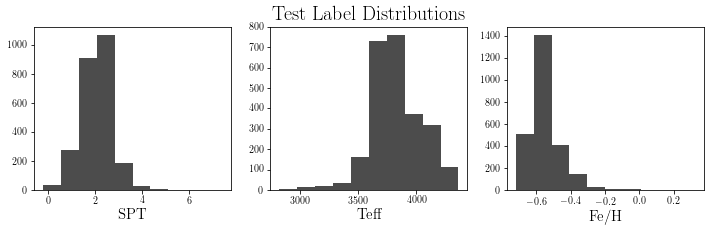

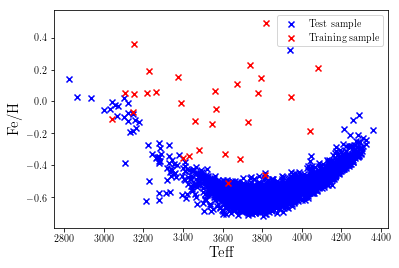

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3), facecolor='w')
ax1.hist(te_spt, color='k', alpha=.7)
ax1.set_xlabel('SPT', fontsize=15)
ax2.hist(te_teff, color='k', alpha=.7)
ax2.set_xlabel('Teff', fontsize=15)
ax3.hist(te_fe_h, color='k', alpha=.7)
ax3.set_xlabel('Fe/H', fontsize=15)
ax2.set_title('Test Label Distributions', fontsize=20)
plt.savefig('2_aganze_results/Test_Label_Distributions.png')
plt.show()
plt.close()

plt.scatter(te_teff, te_fe_h, marker='x', color='b', label='Test sample')
plt.scatter(tr_teff, tr_fe_h, marker='x', color='r', label='Training sample')
plt.xlabel('Teff', fontsize=15)
plt.ylabel('Fe/H', fontsize=15)
plt.legend(loc='upper right')
plt.savefig('2_aganze_results/Test_Label_Scatter.png')
plt.show()
plt.close()

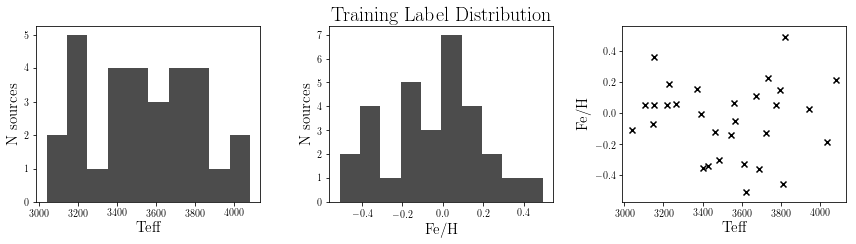

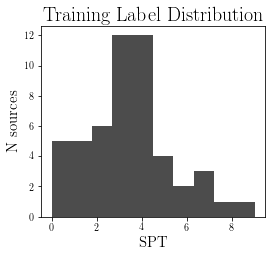

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3.5), facecolor='w')
ax1.hist(tr_teff, color='k', alpha=.7)
ax1.set_xlabel('Teff', fontsize=15)
ax1.set_ylabel('N sources', fontsize=15)
ax2.hist(tr_fe_h, color='k', alpha=.7)
ax2.set_xlabel('Fe/H', fontsize=15)
ax2.set_ylabel('N sources', fontsize=15)
ax3.scatter(tr_teff, tr_fe_h, marker='x', color='k')
ax3.set_xlabel('Teff', fontsize=15)
ax3.set_ylabel('Fe/H', fontsize=15)
ax2.set_title('Training Label Distribution', fontsize=20)
plt.tight_layout()
plt.savefig('2_aganze_results/Mann_Training_Distributions.png')
plt.show()
plt.close()

fig = plt.figure(figsize=(4,3.5)) 
plt.hist(np.transpose(west_ds.tr_label)[0], color='k', alpha=.7)
plt.title('Training Label Distribution', fontsize=20)
plt.xlabel('SPT', fontsize=15)
plt.ylabel('N sources', fontsize=15)
plt.savefig('2_aganze_results/West_Training_Distributions.png')
plt.show()

### Plot models over test spectra

In [ ]:
band = 1
nplots = 10
snr = pd.read_csv(west_rfile)['SNR']
plotCannonModels(spt_ds, west_, spt_label, save=True, out='aganze_results/Models_Band'+str(n)+'.pdf', \
                 tr_lbl_unc=west_tr_unc, te_lbl_unc=[.6], snr=snr, band=band, nplots=nplots)